In [1]:
seed=1226

In [2]:
import warnings
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
import tensorflow as tf


tf.random.set_seed(seed)

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense,Input,Reshape, Flatten,ELU,RepeatVector,TimeDistributed, Bidirectional, PReLU, Concatenate, Subtract
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tqdm import tqdm
from keras.optimizers import Nadam

import glob
import keras
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
# from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# from sklearn.metrics import r2_score
from keras.utils import plot_model
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
np.random.seed(seed)
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from keras.utils import to_categorical
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
# import seaborn as sns
rcParams['figure.figsize']=15,5

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [4]:
from time import time


import pandas as pd
import random

# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,7)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [5]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
Stations = ['Batseri kinnaur','Gharpa','ghoda_farm3_mandi','griffon peak 2','griffon_peak3',
            'kuppa_data','nigulasridata','pagalnala_data','purbani_kinnaur','sanarli_1_mandi','sanarli_3_mandi',
            'sandhol kangra','urni_dhank_kinnaur','griffon peak5 mandi']

In [7]:
Column = ['Date','Tem','Hum','Pressure','Rain','Light','Ax','Ay','Az','Wx','Wy','Wz','Moisture','Count']

In [8]:
seq_len = 10

In [9]:
def matrix(model, Train,TrainL,Test, TestL):
    f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')
    Predict=[]
    True_cls=[]
    test=Train
    y=TrainL

    P=model.predict(test,verbose=0)
    Predict=np.argmax(P,axis=1)
    True_cls=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls, Predict, labels=[0,1])
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp1.plot(ax=axes[0])
    
    disp1.im_.colorbar.remove()

    Predict2=[]
    True_cls2=[]
    test=Test
    y=TestL
    P=model.predict(test,verbose=0)
    Predict2=np.argmax(P,axis=1)
    True_cls2=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls2, Predict2, labels=[0,1])
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp2.plot(ax=axes[1])
    disp2.im_.colorbar.remove()
    
    # Evaluate model accuracy on training and testing sets
    train_loss, train_acc = model.evaluate(Train, TrainL, verbose=0)
    test_loss, test_acc = model.evaluate(Test, TestL, verbose=0)

    # Display accuracy values on subplots
    axes[0].set_title('Training Set\nAccuracy: {:.2f}%'.format(train_acc * 100))
    axes[1].set_title('Testing Set\nAccuracy: {:.2f}%'.format(test_acc * 100))


    
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    plt.show()

In [10]:
#Rearrange the Array
def makeArray(Array):
    New=np.array(Array[0])

    for i in range(1,len(Array)):
        New = np.append(New,Array[i],axis=0)
        
    return New

In [11]:
def readData(Stations):
    
    Data, C = [], []
    
#     print(Stations)
    file = Stations+'.csv'
    newfile = 'deep_'+file
    df = pd.read_csv('Deep_clean_dataset/'+newfile, header=0, index_col=None)
    print(newfile)
    df = df.reset_index(drop=True)
    data=df[['Tem','Hum','Pressure','Rain','Light','Ax','Ay','Az','Wx','Wy','Wz','Moisture','Count']].values
    data=data.astype('float32')
    count=df['Count'].values
    count=count.astype('float32')

    #Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    Data.append(data)
    C.append(count)
   
    return makeArray(Data), makeArray(C)


In [12]:
Data=[[] for x in range(len(Stations))]
Count=[[] for x in range(len(Stations))]
for i in range(len(Stations)):
    Data[i], Count[i] = readData(Stations[i])

deep_Batseri kinnaur.csv
deep_Gharpa.csv
deep_ghoda_farm3_mandi.csv
deep_griffon peak 2.csv
deep_griffon_peak3.csv
deep_kuppa_data.csv
deep_nigulasridata.csv
deep_pagalnala_data.csv
deep_purbani_kinnaur.csv
deep_sanarli_1_mandi.csv
deep_sanarli_3_mandi.csv
deep_sandhol kangra.csv
deep_urni_dhank_kinnaur.csv
deep_griffon peak5 mandi.csv


In [13]:
def make_packet(D, C, seq_len):
    Packet_data = []
    Packet_label = []
    Packet_count = []

    for i in range(len(D)-seq_len):
        Packet_data.append(D[i:i+seq_len,:])
        Packet_label.append(D[i+seq_len,:])
        Packet_count.append(C[i+seq_len])

    Packet_data = np.array(Packet_data)
    Packet_label = np.array(Packet_label)
    Packet_count = np.array(Packet_count).reshape(-1,1)
    
    return Packet_data, Packet_label, Packet_count

def balance_data(d1, l1, c1):
    P1 = []
    L1 = []
    C1 = []
    count = 0
    for i in range(len(c1)):
        if c1[i]>0:
            P1.append(d1[i])
            L1.append(l1[i])
            C1.append(c1[i])
            count+=1

            reset_random_seeds(seed)
    idx = np.random.permutation(len(c1))        

    P2 = []
    L2 = []
    C2 = []
    idx1 = -1
    while count!=0:
        idx1+=1
        if c1[idx[idx1]] == 0:
            P2.append(d1[idx[idx1]])
            L2.append(l1[idx[idx1]])
            C2.append(c1[idx[idx1]])
            count-=1

    #Make the movement count to 1
    #Comment this line if you want to movement count
    C1=list(np.ones((len(C1))).reshape(-1,1))
    
    P1 = P1+P2
    L1 = L1+L2
    C1 = C1+C2
    P1 = np.array(P1)
    L1 = np.array(L1)
    C1 = np.array(C1)
    
    return P1, L1, C1

def mold(D):
    T = []
    for x in D:
        for t in x:
            T.append(t)
            
    return np.array(T)

In [14]:
def train_test(Data, Count, seq_len):
    print("Train:")
    print()
    Train = []
    Train_label = []
    Train_count = []
    S = [0,1,3,5,6,9,10]
    for i in S:
        D = Data[i]
        C = Count[i]
        d1, l1, c1 = make_packet(D, C, seq_len)
        P1, L1, C1 = balance_data(d1, l1, c1)
        print(C1.shape)
        Train.append(P1)
        Train_label.append(L1)
        Train_count.append(C1)

    print("Test:")
    print()
    Test = []
    Test_label = []
    Test_count = []
    S = [2,7,8,4,11,12,13]
    for i in S:
        D = Data[i]
        C = Count[i]
        d1, l1, c1 = make_packet(D, C, seq_len)
        P1, L1, C1 = balance_data(d1, l1, c1)
        print(C1.shape)
        Test.append(P1)
        Test_label.append(L1)
        Test_count.append(C1)

    Train = mold(Train)
    Train_label = mold(Train_label)
    Train_count = mold(Train_count)
    Test = mold(Test)
    Test_label = mold(Test_label)
    Test_count = mold(Test_count)
    
    return Train, Train_label, Train_count, Test, Test_label, Test_count

In [15]:
Auto_Train, Auto_Train_label, Auto_Train_count, Auto_Test, Auto_Test_label, Auto_Test_count = train_test(Data, Count, seq_len)

Train:

(6, 1)
(2, 1)
(950, 1)
(20, 1)
(4, 1)
(4, 1)
(2, 1)
Test:

(0,)
(0,)
(0,)
(928, 1)
(0,)
(0,)
(6, 1)


In [16]:
Auto_Train.shape

(988, 10, 13)

In [17]:
p=0.2
b=5
ft =13

act='relu'
tf.random.set_seed(seed)
np.random.seed(seed)
input_lyr = Input(shape=(ft,))
# N = NoiseLayer(p)(input_lyr)
E = Dense(10, activation=act)(input_lyr)
# E=LeakyReLU(alpha=0.3)(E)

Z = Dense(b, activation=act)(E)
# E=LeakyReLU(alpha=0.3)(Z)

E = Dense(10, activation=act)(Z)
# E=LeakyReLU(alpha=0.3)(E)

output_lyr = Dense(ft)(E)

autoencoder = Model(input_lyr, output_lyr)

# This model maps an input to its encoded representation
encoder = Model(input_lyr, Z)

autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.summary()


Metal device set to: Apple M1 Pro


In [18]:
TrainX = Auto_Train[:,-1]
TestX = Auto_Test[:,-1]

In [19]:
# TrainX = []
# TestX = []

# for x in Data:
#     for y in x:
#         TrainX.append(y)
        
# sz = int(len(TrainX)*0.8)
# TestX = TrainX[sz:]
# TrainX = TrainX[:sz]

In [20]:

callback=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1.0e-4, 
                                          patience=100, verbose=0, mode="auto", 
                                       baseline=None, restore_best_weights=True)
tf.random.set_seed(seed)
np.random.seed(seed)
history = autoencoder.fit(TrainX, TrainX, epochs=500, batch_size=2048, 
                          validation_data=(TestX, TestX), verbose=1, callbacks=[callback])



Epoch 1/500
1/1 [==============================] - 0s 438ms/step - loss: 0.4220 - val_loss: 0.1306
Epoch 2/500
1/1 [==============================] - 0s 28ms/step - loss: 0.4134 - val_loss: 0.1291
Epoch 3/500
1/1 [==============================] - 0s 29ms/step - loss: 0.4052 - val_loss: 0.1276
Epoch 4/500
1/1 [==============================] - 0s 31ms/step - loss: 0.3975 - val_loss: 0.1262
Epoch 5/500
1/1 [==============================] - 0s 29ms/step - loss: 0.3903 - val_loss: 0.1249
Epoch 6/500
1/1 [==============================] - 0s 30ms/step - loss: 0.3835 - val_loss: 0.1237
Epoch 7/500
1/1 [==============================] - 0s 28ms/step - loss: 0.3770 - val_loss: 0.1226
Epoch 8/500
1/1 [==============================] - 0s 29ms/step - loss: 0.3709 - val_loss: 0.1215
Epoch 9/500
1/1 [==============================] - 0s 29ms/step - loss: 0.3651 - val_loss: 0.1205
Epoch 10/500
1/1 [==============================] - 0s 28ms/step - loss: 0.3597 - val_loss: 0.1196
Epoch 11/500
1/1 [

Epoch 84/500
1/1 [==============================] - 0s 26ms/step - loss: 0.1567 - val_loss: 0.0820
Epoch 85/500
1/1 [==============================] - 0s 26ms/step - loss: 0.1543 - val_loss: 0.0812
Epoch 86/500
1/1 [==============================] - 0s 25ms/step - loss: 0.1519 - val_loss: 0.0804
Epoch 87/500
1/1 [==============================] - 0s 25ms/step - loss: 0.1495 - val_loss: 0.0796
Epoch 88/500
1/1 [==============================] - 0s 25ms/step - loss: 0.1471 - val_loss: 0.0788
Epoch 89/500
1/1 [==============================] - 0s 27ms/step - loss: 0.1447 - val_loss: 0.0779
Epoch 90/500
1/1 [==============================] - 0s 25ms/step - loss: 0.1423 - val_loss: 0.0771
Epoch 91/500
1/1 [==============================] - 0s 25ms/step - loss: 0.1399 - val_loss: 0.0763
Epoch 92/500
1/1 [==============================] - 0s 25ms/step - loss: 0.1376 - val_loss: 0.0755
Epoch 93/500
1/1 [==============================] - 0s 26ms/step - loss: 0.1352 - val_loss: 0.0747
Epoch 94/5

1/1 [==============================] - 0s 23ms/step - loss: 0.0477 - val_loss: 0.0621
Epoch 167/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0475 - val_loss: 0.0622
Epoch 168/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0473 - val_loss: 0.0622
Epoch 169/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0471 - val_loss: 0.0623
Epoch 170/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0469 - val_loss: 0.0624
Epoch 171/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0467 - val_loss: 0.0624
Epoch 172/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0465 - val_loss: 0.0625
Epoch 173/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0463 - val_loss: 0.0626
Epoch 174/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0462 - val_loss: 0.0626
Epoch 175/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0460 - val_loss: 0.0627
Epoch 176/500


1/1 [==============================] - 0s 23ms/step - loss: 0.0405 - val_loss: 0.0653
Epoch 249/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0405 - val_loss: 0.0653
Epoch 250/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0404 - val_loss: 0.0652


In [21]:
Encoder_Data = []
for i in range(14):
    D = Data[i]
    Encoder_Data.append(encoder(D).numpy())


In [22]:
LSTM_Train, LSTM_Train_label, LSTM_Train_count, LSTM_Test, LSTM_Test_label, LSTM_Test_count = train_test(Encoder_Data, Count, seq_len)
LSTM_Train_count1=[]

for x in LSTM_Train_count:
    if x[0]==0:
        LSTM_Train_count1.append([1,0])
    else:
        LSTM_Train_count1.append([0,1])
LSTM_Train_count = np.array(LSTM_Train_count1) 

LSTM_Test_count1=[]

for x in LSTM_Test_count:
    if x[0]==0:
        LSTM_Test_count1.append([1,0])
    else:
        LSTM_Test_count1.append([0,1])
LSTM_Test_count = np.array(LSTM_Test_count1)


Train:

(6, 1)
(2, 1)
(950, 1)
(20, 1)
(4, 1)
(4, 1)
(2, 1)
Test:

(0,)
(0,)
(0,)
(928, 1)
(0,)
(0,)
(6, 1)


In [23]:
tf.random.set_seed(seed)
np.random.seed(seed)
model = Sequential()
model.add(Input(shape=(seq_len, b)))
# model.add(LSTM(500,activation='tanh',return_sequences=True))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(2,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# model2.summary()

In [24]:
tf.random.set_seed(seed)
np.random.seed(seed)
H = model.fit(LSTM_Train, LSTM_Train_count, epochs=500,batch_size=512, validation_data=(LSTM_Test, LSTM_Test_count),callbacks=[EarlyStopping(monitor='val_accuracy', patience=50,restore_best_weights=True)],verbose=1, shuffle=True)


Epoch 1/500
2/2 [==============================] - 1s 411ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/500
2/2 [==============================] - 0s 44ms/step - loss: 0.6909 - accuracy: 0.5091 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 3/500
2/2 [==============================] - 0s 49ms/step - loss: 0.6904 - accuracy: 0.5000 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 4/500
2/2 [==============================] - 0s 52ms/step - loss: 0.6897 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 5/500
2/2 [==============================] - 0s 58ms/step - loss: 0.6897 - accuracy: 0.5000 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 6/500
2/2 [==============================] - 0s 65ms/step - loss: 0.6890 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 7/500
2/2 [==============================] - 0s 42ms/step - loss: 0.6871 - accuracy: 0.5000 - val_loss: 0.6954 - val_accuracy: 0.4936
Epoch 8/500
2/2 [==

2/2 [==============================] - 0s 47ms/step - loss: 0.4349 - accuracy: 0.7692 - val_loss: 0.7734 - val_accuracy: 0.5310
Epoch 60/500
2/2 [==============================] - 0s 50ms/step - loss: 0.5413 - accuracy: 0.7672 - val_loss: 0.8160 - val_accuracy: 0.5214
Epoch 61/500
2/2 [==============================] - 0s 42ms/step - loss: 0.4286 - accuracy: 0.7976 - val_loss: 0.6298 - val_accuracy: 0.5889
Epoch 62/500
2/2 [==============================] - 0s 46ms/step - loss: 0.5951 - accuracy: 0.7034 - val_loss: 0.7533 - val_accuracy: 0.5310
Epoch 63/500
2/2 [==============================] - 0s 41ms/step - loss: 0.4446 - accuracy: 0.8006 - val_loss: 0.8088 - val_accuracy: 0.5139
Epoch 64/500
2/2 [==============================] - 0s 47ms/step - loss: 0.4783 - accuracy: 0.7834 - val_loss: 0.7012 - val_accuracy: 0.5514
Epoch 65/500
2/2 [==============================] - 0s 43ms/step - loss: 0.3569 - accuracy: 0.8138 - val_loss: 0.6404 - val_accuracy: 0.5857
Epoch 66/500
2/2 [========

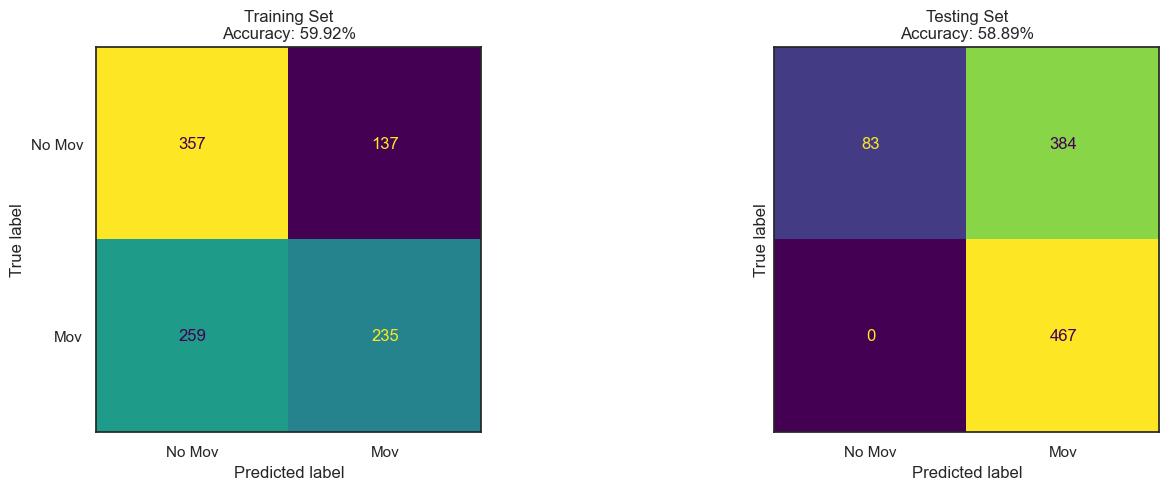

In [25]:
matrix(model,LSTM_Train, LSTM_Train_count,LSTM_Test, LSTM_Test_count)